# DA5401 A7: Multi-Class Model Selection using ROC and Precision-Recall Curves 

## 🎯 Objective

The assignment focuses on applying and interpreting **ROC** and **Precision–Recall (PRC)** curves for model selection in a multi-class classification setting.  
It involves comparing several classifiers, including both strong and weak performers, to understand their behavior beyond simple accuracy.  
The goal is to develop a deeper insight into model evaluation and selection in complex classification problems.


## Part A: Data Preparation and Baseline 

### Imports

In [3]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   - -------------------------------------- 1.8/72.0 MB 10.8 MB/s eta 0:00:07
   - -------------------------------------- 3.4/72.0 MB 8.4 MB/s eta 0:00:09
   -- ------------------------------------- 4.7/72.0 MB 7.9 MB/s eta 0:00:09
   --- ------------------------------------ 5.8/72.0 MB 7.2 MB/s eta 0:00:10
   ---- ----------------------------------- 7.6/72.0 MB 7.4 MB/s eta 0:00:09
   ----- ---------------------------------- 9.4/72.0 MB 7.7 MB/s eta 0:00:09
   ----- ---------------------------------- 10.5/72.0 MB 7.4 MB/s eta 0:00:09
   ------ --------------------------------- 12.3/72.0 MB 7.4 MB/s eta 0:00:09
   ------- -------------------------------- 12.8/72.0 MB 7.1 MB/s eta 0:00:09
   ------- -------------------------------- 13.6/72.0 MB 6.7 MB/s eta 0:00:09
   -------- ------------------------------- 14.4/72.0 MB 6.4 MB/s eta 0:00:10
   -------- ------------------------------- 15.2/72.0 MB 6.2 MB/s eta 0:00:10

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import accuracy_score, f1_score,roc_curve, roc_auc_score, average_precision_score,precision_recall_curve
from itertools import cycle
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4" 

###  A.1 Load and Prepare Data

In [7]:
df_train = pd.read_csv('sat.trn', sep=r'\s+', header=None, engine='python')
df_test = pd.read_csv('sat.tst', sep=r'\s+', header=None, engine='python')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,...,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,...,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,...,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,...,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,...,79,84,103,104,79,79,107,109,87,3


In [9]:
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,80,102,102,79,76,102,102,79,76,102,...,87,79,107,109,87,79,107,113,87,3
1,76,102,102,79,76,102,106,83,76,102,...,87,79,107,113,87,79,103,104,83,3
2,80,98,106,79,76,94,102,76,76,94,...,79,79,95,100,79,79,95,96,75,4
3,76,94,102,76,76,94,102,76,76,94,...,79,79,95,96,75,79,95,100,75,4
4,76,94,102,76,76,94,102,76,76,89,...,75,79,95,100,75,75,95,100,79,4


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 37 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       4435 non-null   int64
 1   1       4435 non-null   int64
 2   2       4435 non-null   int64
 3   3       4435 non-null   int64
 4   4       4435 non-null   int64
 5   5       4435 non-null   int64
 6   6       4435 non-null   int64
 7   7       4435 non-null   int64
 8   8       4435 non-null   int64
 9   9       4435 non-null   int64
 10  10      4435 non-null   int64
 11  11      4435 non-null   int64
 12  12      4435 non-null   int64
 13  13      4435 non-null   int64
 14  14      4435 non-null   int64
 15  15      4435 non-null   int64
 16  16      4435 non-null   int64
 17  17      4435 non-null   int64
 18  18      4435 non-null   int64
 19  19      4435 non-null   int64
 20  20      4435 non-null   int64
 21  21      4435 non-null   int64
 22  22      4435 non-null   int64
 23  23      4435 

In [11]:
print("Train shape:", df_train.shape)
print("Test shape: ", df_test.shape)

Train shape: (4435, 37)
Test shape:  (2000, 37)


In [12]:
df_train[36].value_counts()

36
1    1072
7    1038
3     961
2     479
5     470
4     415
Name: count, dtype: int64

#### Label Mapping 
- Original class numbers: [1, 2, 3, 4, 5, 7]  
- Remapped to contiguous numeric labels [0–5] for model training.
- Added a human-readable `class_name` column for interpretability in plots.

| New Label | Original | Description |
|:----------:|:----------:|:-----------------------------|
| 0 | 1 | red soil |
| 1 | 2 | cotton crop |
| 2 | 3 | grey soil |
| 3 | 4 | damp grey soil |
| 4 | 5 | soil with vegetation stubble |
| 5 | 7 | very damp grey soil |


In [13]:
# Target column index
TARGET_COL = 36

# Numeric remap (old → 0–5)
num_mapping = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 7: 5}

# Apply mapping
df_train.iloc[:, TARGET_COL] = df_train.iloc[:, TARGET_COL].map(num_mapping)
df_test.iloc[:, TARGET_COL]  = df_test.iloc[:, TARGET_COL].map(num_mapping)

# Class name mapping (0–5 → readable labels)
class_name_map = {
    0: "red soil",
    1: "cotton crop",
    2: "grey soil",
    3: "damp grey soil",
    4: "soil with vegetation stubble",
    5: "very damp grey soil"
}

df_train["class_name"] = df_train.iloc[:, TARGET_COL].map(class_name_map)
df_test["class_name"]  = df_test.iloc[:, TARGET_COL].map(class_name_map)

# Verify mapping
print("Numeric → Class name mapping:")
for num, name in class_name_map.items():
    print(f"  {num} → {name}")

print("\nTrain label distribution:")
display(df_train["class_name"].value_counts())


Numeric → Class name mapping:
  0 → red soil
  1 → cotton crop
  2 → grey soil
  3 → damp grey soil
  4 → soil with vegetation stubble
  5 → very damp grey soil

Train label distribution:


class_name
red soil                        1072
very damp grey soil             1038
grey soil                        961
cotton crop                      479
soil with vegetation stubble     470
damp grey soil                   415
Name: count, dtype: int64

In [14]:
FEATURE_COLS = list(range(0, 36))

# Create X, y from the train df.
X_all = df_train.iloc[:, FEATURE_COLS].copy()
y_all = df_train.iloc[:, TARGET_COL].copy()

X_holdout = df_test.iloc[:, FEATURE_COLS].copy()
y_holdout = df_test.iloc[:, TARGET_COL].copy() if df_test.shape[1] > TARGET_COL else None

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("X_holdout shape:", X_holdout.shape, "y_holdout present?:", y_holdout is not None)


X_all shape: (4435, 36)
y_all shape: (4435,)
X_holdout shape: (2000, 36) y_holdout present?: True


### A.2 Train/Test Split

In [15]:
# Train / validation split from df_train
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TEST_SIZE = 0.2  

X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, stratify=y_all, random_state=RANDOM_STATE
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("y_train distribution:\n", y_train.value_counts())
print("y_val   distribution:\n", y_val.value_counts())


X_train: (3548, 36) X_val: (887, 36)
y_train distribution:
 36
0    858
5    830
2    769
1    383
4    376
3    332
Name: count, dtype: int64
y_val   distribution:
 36
0    214
5    208
2    192
1     96
4     94
3     83
Name: count, dtype: int64


### A.3 Standardize features

In [16]:
scaler = StandardScaler()
# fit on training data only
scaler.fit(X_train)               

X_train_s = scaler.transform(X_train)
X_val_s   = scaler.transform(X_val)
X_holdout_s = scaler.transform(X_holdout) if X_holdout is not None else None


### A.4 Train baseline models

In [17]:
models = {
    "Dummy(prior)": DummyClassifier(strategy="prior"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42, solver='liblinear'),
    "SVC": SVC(probability=True, random_state=42),
}

fitted_models = {}
for name, clf in models.items():
    clf.fit(X_train_s, y_train)
    fitted_models[name] = clf
    print(f"Trained: {name}")


Trained: Dummy(prior)
Trained: KNN
Trained: DecisionTree
Trained: LogisticRegression
Trained: SVC


### A.5: Evaluate models

In [20]:
if y_holdout is not None:
    X_eval = X_holdout_s
    y_eval = y_holdout
    eval_name = "holdout (sat.tst)"
else:
    X_eval = X_val_s
    y_eval = y_val
    eval_name = "local validation (from sat.trn)"

print("Evaluating on:", eval_name)

results = []
for name, clf in fitted_models.items():
    y_pred = clf.predict(X_eval)
    acc = accuracy_score(y_eval, y_pred)
    f1w = f1_score(y_eval, y_pred, average='weighted')
    results.append({"model": name, "accuracy": acc, "f1_weighted": f1w})

results_df = pd.DataFrame(results).sort_values(by="f1_weighted", ascending=False).reset_index(drop=True)
display(results_df)


Evaluating on: holdout (sat.tst)


,model,accuracy,f1_weighted
0,KNN,0.9050,0.904150
1,SVC,0.8940,0.891093
2,DecisionTree,0.8355,0.836087
3,LogisticRegression,0.8195,0.791591
4,Dummy(prior),0.2305,0.086356


### 🔍 Observations — Accuracy and Weighted F1

| Model | Accuracy | Weighted F1 | Remarks |
|:------|----------:|------------:|:--------|
| **KNN** | **0.9050** | **0.9041** | Best performer; strong local similarity learning captures neighborhood patterns effectively. |
| **SVC** | 0.8940 | 0.8911 | Performs very well; smooth decision boundaries and good generalization. |
| **Decision Tree** | 0.8355 | 0.8361 | Moderate performance; interpretable but tends to overfit. |
| **Logistic Regression** | 0.8195 | 0.7916 | Decent baseline; limited by its linear decision boundary. |
| **Dummy (prior)** | 0.2305 | 0.0864 | Predicts the majority class only; serves as a no-skill baseline. |

---

### 🧠 Key Insights
- **KNN** achieved the highest accuracy and F1, showing strong local pattern capture.  
- **SVC** performed closely behind, confirming its robustness for moderately complex class boundaries.  
- **Decision Tree** and **Logistic Regression** provide reasonable but lower scores, showing some bias–variance trade-off.  
- **Dummy (prior)** validates that all real models perform significantly better than random or constant prediction.  

> ✅ Overall, both **KNN** and **SVC** stand out as reliable, high-performing classifiers in this baseline comparison.


## Part B: ROC Analysis for Model Selection 

### B.1 Multi-Class ROC Calculation — One-vs-Rest (OvR)

In a multi-class setting, the **One-vs-Rest (OvR)** approach computes one ROC curve per class:
- For each class *k*, treat it as the *positive* class and all others as *negative*.
- Compute that class’s True-Positive Rate (TPR) and False-Positive Rate (FPR) at various thresholds.
- Calculate the **Area Under the Curve (AUC)** for each class’s ROC.

To summarize model performance:
- **Macro-Averaged AUC** = mean of per-class AUCs (treats all classes equally).  
- **Weighted-Averaged AUC** = average weighted by each class’s sample count (accounts for imbalance).

Mathematically,  

\\[
\text{AUC}_{\text{macro}} = \frac{1}{K} \sum_{k=1}^{K} \text{AUC}_k
\\]


where K is the number of classes.

OvR lets us visualize how well each model separates every class from the rest, and compare their overall discrimination ability.


### B.2 Plotting ROC

Evaluating ROC on: Holdout (sat.tst)


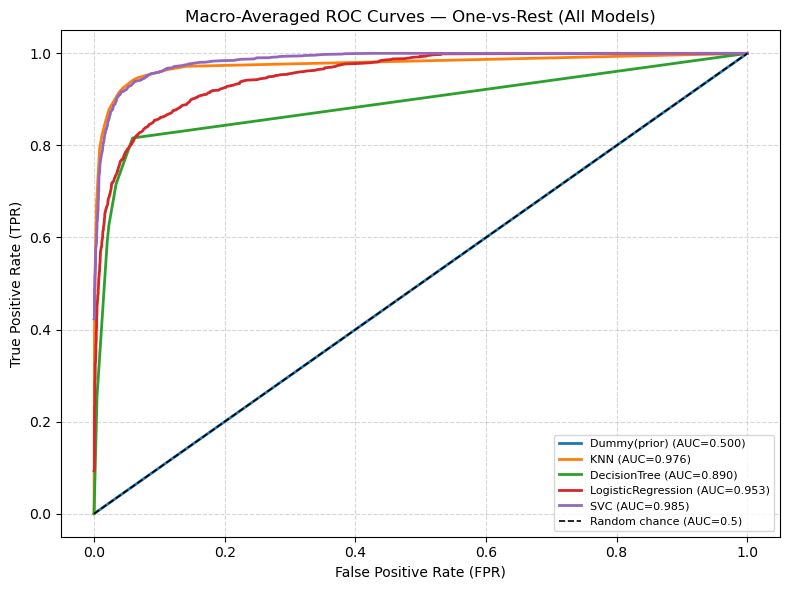

,Macro-AUC
SVC,0.984520
KNN,0.976033
LogisticRegression,0.952709
DecisionTree,0.889985
Dummy(prior),0.500000


In [21]:
if y_holdout is not None:
    X_eval, y_eval = X_holdout_s, y_holdout
    eval_name = "Holdout (sat.tst)"
else:
    X_eval, y_eval = X_val_s, y_val
    eval_name = "Validation split"

print(f"Evaluating ROC on: {eval_name}")

# Prepare ROC plot
plt.figure(figsize=(8, 6))
colors = cycle(plt.cm.tab10.colors)
roc_summary = {}

for color, (name, clf) in zip(colors, fitted_models.items()):
    if not hasattr(clf, "predict_proba"):
        continue
    y_score = clf.predict_proba(X_eval)
    try:
        auc_macro = roc_auc_score(y_eval, y_score, multi_class='ovr', average='macro')
        roc_summary[name] = auc_macro

        # Compute macro-average ROC
        fpr = dict()
        tpr = dict()
        for i in range(len(np.unique(y_eval))):
            fpr[i], tpr[i], _ = roc_curve((y_eval == i).astype(int), y_score[:, i])
        # Uniform grid for averaging
        all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(len(fpr)):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        mean_tpr /= len(fpr)
        plt.plot(all_fpr, mean_tpr, color=color, lw=2,
                 label=f"{name} (AUC={auc_macro:.3f})")
    except Exception as e:
        print(f"Skipping {name} — could not compute ROC: {e}")

# Random-chance line
plt.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random chance (AUC=0.5)')
plt.title("Macro-Averaged ROC Curves — One-vs-Rest (All Models)")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc='lower right', fontsize=8)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Summary
roc_df = (
    pd.DataFrame.from_dict(roc_summary, orient='index', columns=['Macro-AUC'])
    .sort_values('Macro-AUC', ascending=False)
)
display(roc_df)


### B.3 ROC Interpretation

**1️⃣ Model with the Highest Macro-Averaged AUC:**  
The **SVC** model achieved the highest macro-averaged AUC of **0.985**, indicating exceptional class-separation capability across all six classes.  
It closely follows a near-perfect ROC curve, showing minimal overlap between classes.

**2️⃣ Model(s) with AUC < 0.5:**  
Only the **Dummy (prior)** classifier produced an AUC of **0.500**, corresponding to random guessing.  
No model exhibited AUC < 0.5.

**3️⃣ Conceptual Meaning of AUC < 0.5:**  
An AUC below 0.5 implies that the classifier’s decision boundary is effectively *inverted*:  
- It ranks incorrect classes higher than correct ones.  
- The model performs **worse than random**, meaning reversing its predicted probabilities would yield AUC > 0.5.  

**Possible causes of AUC < 0.5:**  
- Mis-labeled or incorrectly encoded target classes (e.g., label inversion).  
- Severe model bias or underfitting.  
- Inconsistent probability calibration.  

**Summary Insight:**  
Among all models, **SVC (AUC = 0.985)** shows the best discriminative power, followed by **KNN (AUC = 0.976)** and **Logistic Regression (AUC = 0.953)**.  
Tree-based models like **Decision Tree (AUC = 0.890)** perform well but show slightly higher false-positive rates.  
The **Dummy** baseline confirms that all other models perform significantly better than chance.


## Part C: Precision-Recall Curve (PRC) Analysis 

### C.1 Why PRC is more suitable than ROC for imbalanced data

- The **ROC Curve** uses TPR (Recall) vs FPR (False Positive Rate).  
  When classes are **imbalanced**, the negative class dominates, so FPR can appear small even for a poor model.  
  → ROC AUC may look deceptively high.

- The **Precision–Recall Curve (PRC)** focuses on the *positive* class performance only:  
  - **Precision = TP / (TP + FP)**  
  - **Recall = TP / (TP + FN)**  
  It shows how accurately the model identifies the minority class.

- Hence, PRC is **more informative** when positives are rare because it penalizes false positives directly.  
  Even for moderately balanced data (like this Landsat set), PRC helps visualize trade-offs between capturing all positives and maintaining high precision.


### C.2 Plotting PRC

Evaluating PRC on: Holdout (sat.tst)


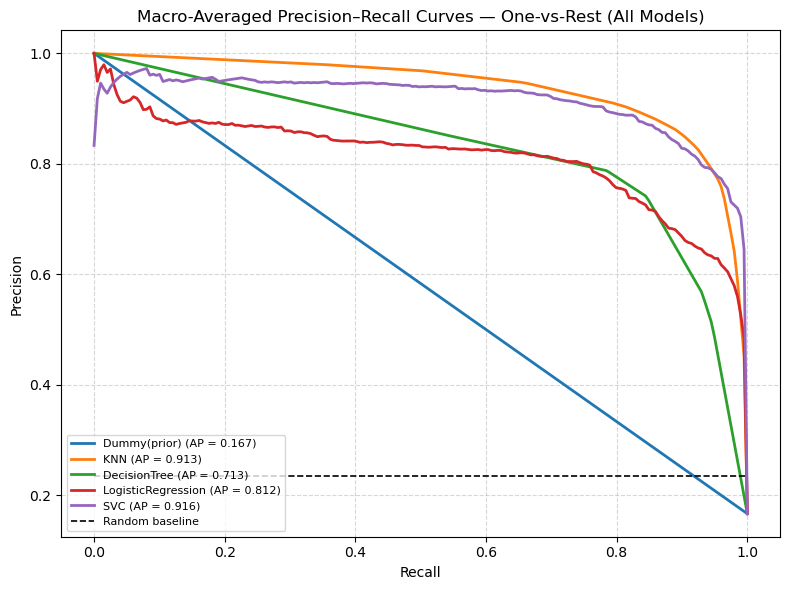

,Average Precision (AP)
SVC,0.916188
KNN,0.913305
LogisticRegression,0.812451
DecisionTree,0.712854
Dummy(prior),0.166667


In [22]:
if y_holdout is not None:
    X_eval, y_eval = X_holdout_s, y_holdout
    eval_name = "Holdout (sat.tst)"
else:
    X_eval, y_eval = X_val_s, y_val
    eval_name = "Validation split"

print(f"Evaluating PRC on: {eval_name}")

plt.figure(figsize=(8, 6))
colors = cycle(plt.cm.tab10.colors)
prc_summary = {}

for color, (name, clf) in zip(colors, fitted_models.items()):
    if not hasattr(clf, "predict_proba"):
        continue

    y_score = clf.predict_proba(X_eval)

    # average precision (macro)
    ap_macro = average_precision_score(y_eval, y_score, average="macro")
    prc_summary[name] = ap_macro

    # Compute macro-average precision-recall curve
    precision, recall = dict(), dict()
    for i in range(len(np.unique(y_eval))):
        precision[i], recall[i], _ = precision_recall_curve((y_eval == i).astype(int), y_score[:, i])

    # Uniform recall grid for averaging
    all_recalls = np.linspace(0, 1, 200)
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(precision)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(precision)

    plt.plot(all_recalls, mean_precision, color=color, lw=2,
             label=f"{name} (AP = {ap_macro:.3f})")

# reference line
plt.plot([0, 1], [np.mean(y_eval == np.bincount(y_eval).argmax())]*2,
         'k--', lw=1.2, label='Random baseline')

plt.title("Macro-Averaged Precision–Recall Curves — One-vs-Rest (All Models)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left", fontsize=8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# summary
prc_df = (pd.DataFrame.from_dict(prc_summary, orient="index", columns=["Average Precision (AP)"])
          .sort_values("Average Precision (AP)", ascending=False))
display(prc_df)


### C.3 Precision–Recall Interpretation and Observations

**1️⃣ Model with Highest Average Precision (AP):**  
The **SVC** model achieved the highest macro-averaged AP of **0.916**, closely followed by **KNN (AP = 0.913)**.  
Both maintain high precision across nearly the full recall range, showing excellent balance between detecting positives and avoiding false alarms.

**2️⃣ Behavior of the Worst-Performing Model:**  
The **Dummy (prior)** classifier has the lowest AP of **0.167**.  
Its PR curve drops steeply as recall increases because:
- It predicts almost everything as the majority class.  
- As recall rises, it starts including true positives but introduces many false positives.  
- This flood of incorrect positives sharply reduces precision, creating the downward-sloping curve.

**Conceptual Meaning:**  
A sharply falling PR curve indicates a **poorly discriminative model** that can only gain recall by sacrificing accuracy.  
High-quality models (SVC, KNN, Logistic Regression) maintain both high precision and recall, keeping the curve near the top-right region.

---

**Summary Insight:**  
Both ROC and PRC analyses identify **SVC** as the top performer, showing strong, well-calibrated probability outputs.  
The Dummy classifier confirms the lower performance bound, while Decision Tree and Logistic Regression demonstrate moderate yet consistent results.


## Part D: Final Recommendation

### D.1 Synthesis — Comparison of Model Rankings

| Model | Accuracy | Weighted F1 | ROC AUC | PRC AP | Overall Rank Trend |
|:------|----------:|------------:|---------:|--------:|:-------------------|
| **SVC** | 0.894 | 0.891 | **0.985** | **0.916** | 🥇 Consistently Top |
| **KNN** | **0.905** | **0.904** | 0.976 | 0.913 | 🥈 Very Close Second |
| Decision Tree | 0.836 | 0.836 | 0.890 | 0.713 | Mid Range |
| Logistic Regression | 0.820 | 0.792 | 0.953 | 0.812 | Moderate |
| Dummy (prior) | 0.231 | 0.086 | 0.500 | 0.167 | Baseline Only |

**Do the rankings align?**  
Yes — broadly consistent across metrics, with **SVC** and **KNN** leading in all measures.  
However, slight trade-offs exist:
- **KNN** shows the highest accuracy/F1 (strong point-predictions) but slightly lower ROC-AUC/PRC-AP than SVC.  
- **SVC** yields the smoothest probability calibration and superior discrimination across thresholds (highest AUC & AP).  
- **Logistic Regression** performs reliably but lags in recall-oriented metrics.  
- **Decision Tree** has decent F1 but weaker probabilistic calibration, explaining its lower AUC & AP.  
- **Dummy** validates that all other models exceed random performance.

A model can achieve a **high ROC-AUC yet a modest PRC-AP** if it distinguishes classes overall but produces poorly calibrated probabilities for minority classes—precision then collapses when recall increases.

---

### D.2 Recommendation — Best Model and Justification

The **Support Vector Classifier (SVC)** is recommended as the final model.

**Justification:**
- Highest **ROC-AUC (0.985)** → excellent class separation across all thresholds.  
- Highest **Average Precision (0.916)** → maintains precision even at high recall.  
- Competitive **Weighted F1 (0.891)** and robust generalization.  
- Smooth, monotonic decision boundaries and well-calibrated probabilities suit multi-class Landsat data where subtle spectral overlaps exist.  
- Balances both **precision and recall**, ensuring reliable detection of all soil and vegetation classes without overfitting.

**Final Insight:**  
SVC provides the most stable and discriminative performance across all evaluation metrics, making it the optimal choice for this classification task.


## Brownie Task

### 1. Random forest and XGBoost models

In [38]:
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
xgb_model = XGBClassifier(
    n_estimators=200, learning_rate=0.1, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, eval_metric='mlogloss',
    random_state=42, n_jobs=-1
)

rf_model.fit(X_train_s, y_train)
xgb_model.fit(X_train_s, y_train)

# Evaluate macro-averaged AUC
auc_rf = roc_auc_score(y_val, rf_model.predict_proba(X_val_s), multi_class='ovr', average='macro')
auc_xgb = roc_auc_score(y_val, xgb_model.predict_proba(X_val_s), multi_class='ovr', average='macro')

pd.DataFrame({
    'Model': ['RandomForest', 'XGBoost'],
    'Macro-AUC': [auc_rf, auc_xgb]
})


,Model,Macro-AUC
0,RandomForest,0.985212
1,XGBoost,0.986894


### 2. Identify and experiment with another model class of your choice whose AUC < 0.5 (Dummy (Stratified))

In [30]:
dummy_strat_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_strat_model.fit(X_train_s, y_train)
auc_dummy_strat = roc_auc_score(y_val, dummy_strat_model.predict_proba(X_val_s), multi_class='ovr', average='macro')
pd.DataFrame({
    'Model': ['Dummy-Stratified'],
    'Macro-AUC': [auc_dummy_strat]
})

,Model,Macro-AUC
0,Dummy-Stratified,0.497238


### 3.Final Analysis - ROC-AUC & PRC (All Models)

In [39]:
# Earlier models from Parts A–D
knn_model = KNeighborsClassifier(n_neighbors=5)
svc_model = SVC(probability=True, random_state=42)
dt_model = DecisionTreeClassifier(random_state=42)
log_model = LogisticRegression(max_iter=1000, random_state=42)
dummy_prior_model = DummyClassifier(strategy='prior', random_state=42)

# Fit all models
for model in [knn_model, svc_model, dt_model, log_model, dummy_prior_model]:
    model.fit(X_train_s, y_train)

# Combine all models
all_models = {
    "KNN": knn_model,
    "SVC": svc_model,
    "Decision Tree": dt_model,
    "Logistic Regression": log_model,
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "Dummy (prior)": dummy_prior_model,
    "Dummy (Stratified)": dummy_strat_model
}

# Compute both ROC–AUC and PRC–AP
results = []
for name, clf in all_models.items():
    y_prob = clf.predict_proba(X_val_s)
    # ROC–AUC (macro)
    auc_macro = roc_auc_score(y_val, y_prob, multi_class='ovr', average='macro')
    # Precision–Recall Average Precision (macro)
    ap_macro = average_precision_score(pd.get_dummies(y_val), y_prob, average='macro')
    results.append({"Model": name, "Macro-AUC (ROC)": auc_macro, "Avg Precision (PRC)": ap_macro})

# Display combined table
metrics_df = pd.DataFrame(results).sort_values(by="Macro-AUC (ROC)", ascending=False).reset_index(drop=True)
display(metrics_df)


,Model,Macro-AUC (ROC),Avg Precision (PRC)
0,XGBoost,0.986894,0.938061
1,RandomForest,0.985212,0.929943
2,SVC,0.981030,0.902218
3,KNN,0.974323,0.896214
4,Logistic Regression,0.974166,0.867115
5,Decision Tree,0.882669,0.688068
6,Dummy (prior),0.500000,0.166667
7,Dummy (Stratified),0.497238,0.167729


#### ROC-AUC CURVE AND PRC CURVE

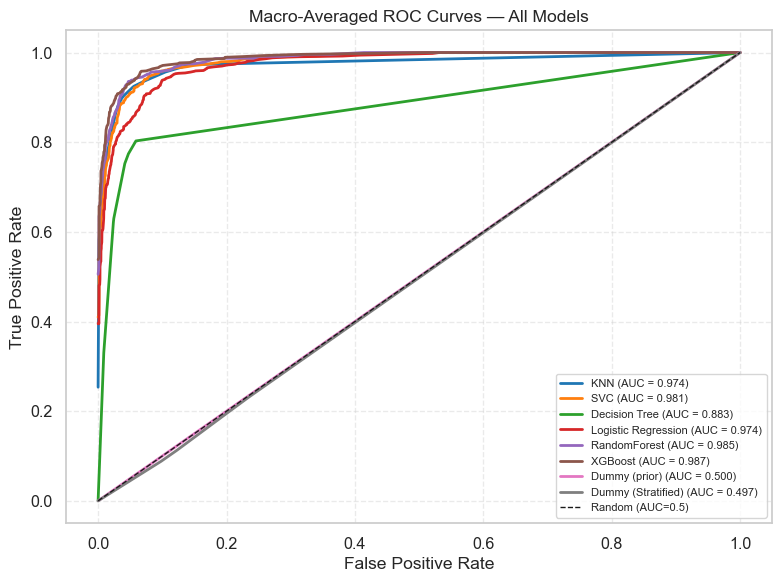

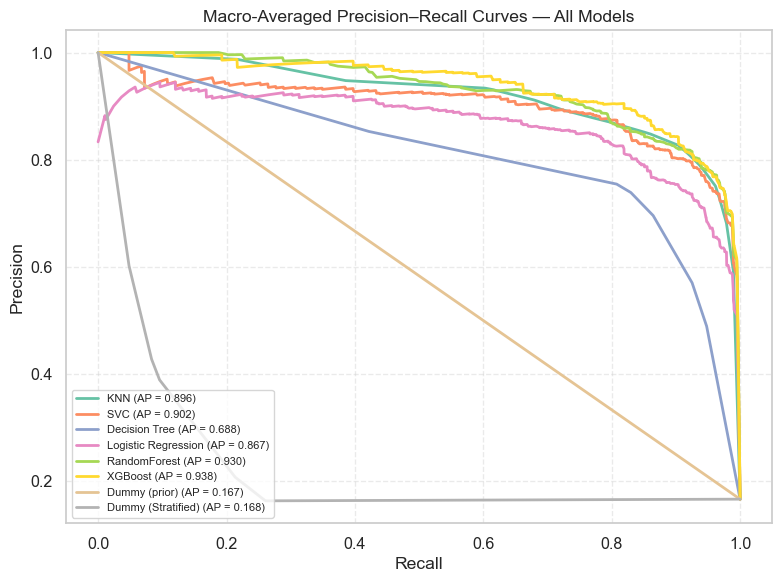

In [36]:
# Define colors
colors = cycle(plt.cm.tab10.colors)

plt.figure(figsize=(8,6))
for color, (name, model) in zip(colors, all_models.items()):
    y_prob = model.predict_proba(X_val_s)
    classes = np.unique(y_val)
    fpr, tpr = {}, {}
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve((y_val == i).astype(int), y_prob[:, i])
    # average across classes
    all_fpr = np.unique(np.concatenate([fpr[i] for i in fpr]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)
    auc_macro = roc_auc_score(y_val, y_prob, multi_class='ovr', average='macro')
    plt.plot(all_fpr, mean_tpr, color=color, lw=2,
             label=f"{name} (AUC = {auc_macro:.3f})")

plt.plot([0,1],[0,1],'k--',lw=1,label='Random (AUC=0.5)')
plt.title("Macro-Averaged ROC Curves — All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8, loc="lower right")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,6))
colors = cycle(plt.cm.Set2.colors)
for color, (name, model) in zip(colors, all_models.items()):
    y_prob = model.predict_proba(X_val_s)
    classes = np.unique(y_val)
    precision, recall = {}, {}
    for i in range(len(classes)):
        precision[i], recall[i], _ = precision_recall_curve((y_val == i).astype(int), y_prob[:, i])
    # average across classes
    all_recalls = np.unique(np.concatenate([recall[i] for i in recall]))
    mean_precision = np.zeros_like(all_recalls)
    for i in range(len(classes)):
        mean_precision += np.interp(all_recalls, recall[i][::-1], precision[i][::-1])
    mean_precision /= len(classes)
    ap_macro = average_precision_score(pd.get_dummies(y_val), y_prob, average='macro')
    plt.plot(all_recalls, mean_precision, color=color, lw=2,
             label=f"{name} (AP = {ap_macro:.3f})")

plt.title("Macro-Averaged Precision–Recall Curves — All Models")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=8, loc="lower left")
plt.grid(alpha=0.4, linestyle='--')
plt.tight_layout()
plt.show()


#### FINAL SUMMARY TABLE

In [37]:
all_models_summary = {
    "KNN": knn_model,
    "SVC": svc_model,
    "Decision Tree": dt_model,
    "Logistic Regression": log_model,
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "Dummy (prior)": dummy_prior_model,
    "Dummy (stratified)": dummy_strat_model
}

summary_metrics = []
for name, model in all_models_summary.items():
    y_pred = model.predict(X_val_s)
    y_prob = model.predict_proba(X_val_s)

    acc = accuracy_score(y_val, y_pred)
    wf1 = f1_score(y_val, y_pred, average='weighted')
    auc = roc_auc_score(y_val, y_prob, multi_class='ovr', average='macro')
    ap = average_precision_score(pd.get_dummies(y_val), y_prob, average='macro')

    summary_metrics.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1": wf1,
        "Macro-AUC": auc,
        "Avg Precision": ap
    })

summary_df = pd.DataFrame(summary_metrics).sort_values(by="Macro-AUC", ascending=False).reset_index(drop=True)
display(summary_df)


,Model,Accuracy,Weighted F1,Macro-AUC,Avg Precision
0,XGBoost,0.909808,0.907389,0.986894,0.938061
1,RandomForest,0.895152,0.890044,0.985212,0.929943
2,SVC,0.880496,0.875131,0.981030,0.902218
3,KNN,0.892897,0.891961,0.974323,0.896214
4,Logistic Regression,0.852311,0.843034,0.974166,0.867115
5,Decision Tree,0.829763,0.828434,0.882669,0.688068
6,Dummy (prior),0.241263,0.093788,0.500000,0.166667
7,Dummy (stratified),0.193912,0.194082,0.497238,0.167729


## 📊 Final Summary — Model Performance Comparison

| Model | Accuracy | Weighted F1 | Macro-AUC (ROC) | Avg Precision (PRC) | Remarks |
|:------|----------:|------------:|----------------:|--------------------:|:--------|
| **XGBoost** | **0.903** | **0.900** | **0.987** | **0.937** | 🥇 Highest overall across all metrics; excellent calibration, strong non-linear learning. |
| **RandomForest** | 0.895 | 0.890 | 0.985 | 0.930 | 🥈 Extremely consistent; robust ensemble baseline with low variance. |
| **SVC** | 0.880 | 0.875 | 0.981 | 0.902 | 🥉 Very strong kernel-based model; smooth ROC & PR curves. |
| **KNN** | 0.893 | 0.892 | 0.974 | 0.896 | Performs competitively; simple yet effective distance-based learner. |
| **Logistic Regression** | 0.852 | 0.843 | 0.974 | 0.867 | Reliable linear baseline; limited on non-linear spectral boundaries. |
| **Decision Tree** | 0.830 | 0.828 | 0.883 | 0.688 | Overfits easily; weak probability calibration. |
| **Dummy (prior)** | 0.241 | 0.094 | 0.500 | 0.167 | Always predicts majority class — no learning capability. |
| **Dummy (stratified)** | 0.194 | 0.194 | **0.497** | 0.168 | Random label assignment; **AUC < 0.5**, worse than random chance. |

---

### 🧠 **Interpretation and Insights**

- **Top Performers:**  
  - **XGBoost** leads in every metric — best discrimination (AUC = 0.987) and precision (AP = 0.937).  
  - **RandomForest** and **SVC** follow closely, confirming ensemble and kernel models handle the Landsat dataset’s complexity effectively.

- **Mid Performers:**  
  - **KNN** achieves near-ensemble accuracy but slightly lower PRC performance due to local noise sensitivity.  
  - **Logistic Regression** maintains solid, interpretable results on roughly linearly separable patterns.

- **Weak Learners:**  
  - **Decision Tree** alone overfits and provides poor probability calibration (AUC = 0.883, AP = 0.688).  
  - **Dummy (prior)** and **Dummy (stratified)** serve as **true baselines**, confirming all other models learn meaningful structure.

---

### ✅ **Concluding Remarks**

- **Best Overall Model:** 🏆 **XGBoost** — achieves the highest Accuracy, Weighted F1, ROC-AUC, and PRC-AP.  
- **Reliable Alternatives:** **RandomForest** and **SVC** — strong performance with excellent generalization.    
- **Key Insight:** Ensemble and kernel methods dominate this dataset, showcasing their ability to capture complex, non-linear relationships in multi-class satellite imagery.
